## Imports

In [1]:
import logging  # Allows you to set levels of verbosity for printing information warnings and errors
import elfi  # SMC / Liklihood free inference
import numpy as np  # Matrices and linear algebra
import scipy.stats  # Statistics
import seaborn as sns  # Plotting
import matplotlib.pyplot as plt  # Plotting
from sklearn.preprocessing import StandardScaler  # Carries out standard scaling (x-mu)/sd
import pandas as pd  # DataFrames
import pickle  # Serializes objects

import torch
import torch.distributions
from torch import Tensor
from sbi.inference import SNLE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.user_input_checks import process_prior
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis

from sim.utils import ScaledDist
from sim.model import simple_sim
from sim.sum_stats import simple_sum

import snle.priors_torch as priors

# Set the logging level to info
logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)


## The data

In [2]:
priors_df = pd.read_feather("./snle/reference_table/priors.feather")
priors_df

,bottleneck_strength_domestic,bottleneck_strength_wild,bottleneck_time_domestic,bottleneck_time_wild,captive_time,div_time,mig_length_post_split,mig_length_wild,mig_rate_captive,mig_rate_post_split,mig_rate_wild,pop_size_wild_1,pop_size_wild_2,pop_size_captive,pop_size_domestic_1,pop_size_domestic_2
0,11179.681200,8581.601075,3654.899668,3291.806520,13.502363,46680.457221,6346.826923,16.202815,0.058944,0.116402,0.072175,6255.730274,7945.064619,133.534390,6451.196306,7699.512587
1,20482.341086,16404.120378,4232.065306,3728.075174,22.553406,44641.534301,4880.812376,13.077160,0.059210,0.109968,0.176588,6877.912755,5949.057501,154.701628,7971.442694,11450.314844
2,3.369323,3523.450783,3774.345412,3685.196173,7.229414,42802.803862,3277.696186,20.579393,0.071179,0.559360,0.065024,5256.207158,10799.396570,117.361874,6112.577699,9694.793723
3,8161.556827,9239.064011,3753.769579,3756.369852,14.865991,36737.027154,2062.518501,10.036191,0.184065,0.195405,0.096693,5949.903606,5668.604996,152.402764,8791.844465,10339.598508
4,4087.355058,21417.550593,4059.054514,2303.246484,27.651080,43950.048934,5090.117954,15.307157,0.067246,0.003630,0.041867,7566.267953,8116.905291,50.868131,7052.261649,8565.590984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,22337.178123,14050.553065,3908.135645,3584.050662,11.765509,39649.378349,1340.414076,9.771375,0.106375,0.061741,0.033449,5184.411438,9794.646223,195.638323,8822.669036,9705.442206
99996,20718.163193,8499.451967,3064.211557,3036.349459,24.288717,38495.053565,2632.633453,13.963054,0.085125,0.069547,0.056966,3568.986005,6641.849287,80.036764,4977.315238,8860.636900
99997,24696.026623,11831.469390,3427.699827,2889.307423,77.532798,35627.801725,5356.465390,22.681174,0.152741,0.313056,0.073686,5307.554627,10252.375193,88.807619,7840.280991,9077.421032
99998,15417.261143,31954.932104,2880.890665,4139.999980,16.976664,41201.706085,1882.719653,9.088074,0.062959,0.181357,0.047085,5792.970550,8216.534274,82.485428,5769.718597,10413.756290


In [3]:
stats_df = pd.read_csv("./snle/reference_table/summary_stats.csv")
stats_df

,divergence_domestic_captive,divergence_domestic_wild,divergence_wild_captive,diversity_all_pops,diversity_captive,diversity_domestic,diversity_wild,expected_heterozygosity_all_pops,expected_heterozygosity_captive,expected_heterozygosity_domestic,...,sfs_mean_wild_6_12,tajimas_d_all_pops,tajimas_d_captive,tajimas_d_domestic,tajimas_d_wild,wattersons_theta_all_pops,wattersons_theta_captive,wattersons_theta_domestic,wattersons_theta_wild,random_seed
0,0.007880,0.005410,0.003691,0.004301,0.001613,0.000467,0.004320,0.277301,0.099927,0.027377,...,3434.833333,1.457091,-1.733647,-1.335452,1.520959,0.003024,0.002748,0.000635,0.003035,200.0
1,0.006267,0.003160,0.005472,0.004389,0.004025,0.001529,0.003970,0.274606,0.241924,0.087072,...,26878.000000,1.413265,0.842269,0.151744,0.877846,0.003114,0.003352,0.001484,0.003191,201.0
2,0.001354,0.001068,0.001415,0.001243,0.001668,0.001013,0.001133,0.081738,0.105386,0.060625,...,9256.333333,-1.916019,-1.500576,-0.468063,-1.652315,0.002793,0.002595,0.001117,0.002097,202.0
3,0.004093,0.002857,0.003991,0.003560,0.003873,0.001478,0.003466,0.241507,0.252361,0.091230,...,17933.000000,0.825368,1.300359,0.038516,0.689328,0.002873,0.002957,0.001467,0.002908,203.0
4,0.004661,0.003469,0.004701,0.004300,0.004721,0.000972,0.004308,0.280508,0.295850,0.057707,...,12050.833333,1.514436,1.782652,-0.062027,1.475781,0.002989,0.003313,0.000984,0.003054,204.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73995,0.003564,0.003362,0.004007,0.003810,0.004146,0.002748,0.003847,0.187806,0.196335,0.123272,...,33807.666667,-0.122137,-0.124890,0.291447,-0.181348,0.003950,0.004274,0.002597,0.004052,79995.0
73996,0.006010,0.003620,0.004889,0.004409,0.003859,0.001088,0.004315,0.311035,0.261489,0.069816,...,7189.666667,2.055021,1.120441,0.033833,1.893960,0.002764,0.003046,0.001080,0.002826,79996.0
73997,0.003620,0.001682,0.003758,0.002863,0.003889,0.000307,0.002525,0.210979,0.275351,0.020564,...,41860.000000,0.286947,1.451825,-1.226246,-0.150434,0.002643,0.002890,0.000406,0.002635,79997.0
73998,0.004008,0.003357,0.004713,0.004311,0.005012,0.001351,0.004396,0.256376,0.286332,0.073124,...,32663.666667,1.087298,1.353599,0.234265,1.069016,0.003278,0.003790,0.001291,0.003388,79998.0


## Setup

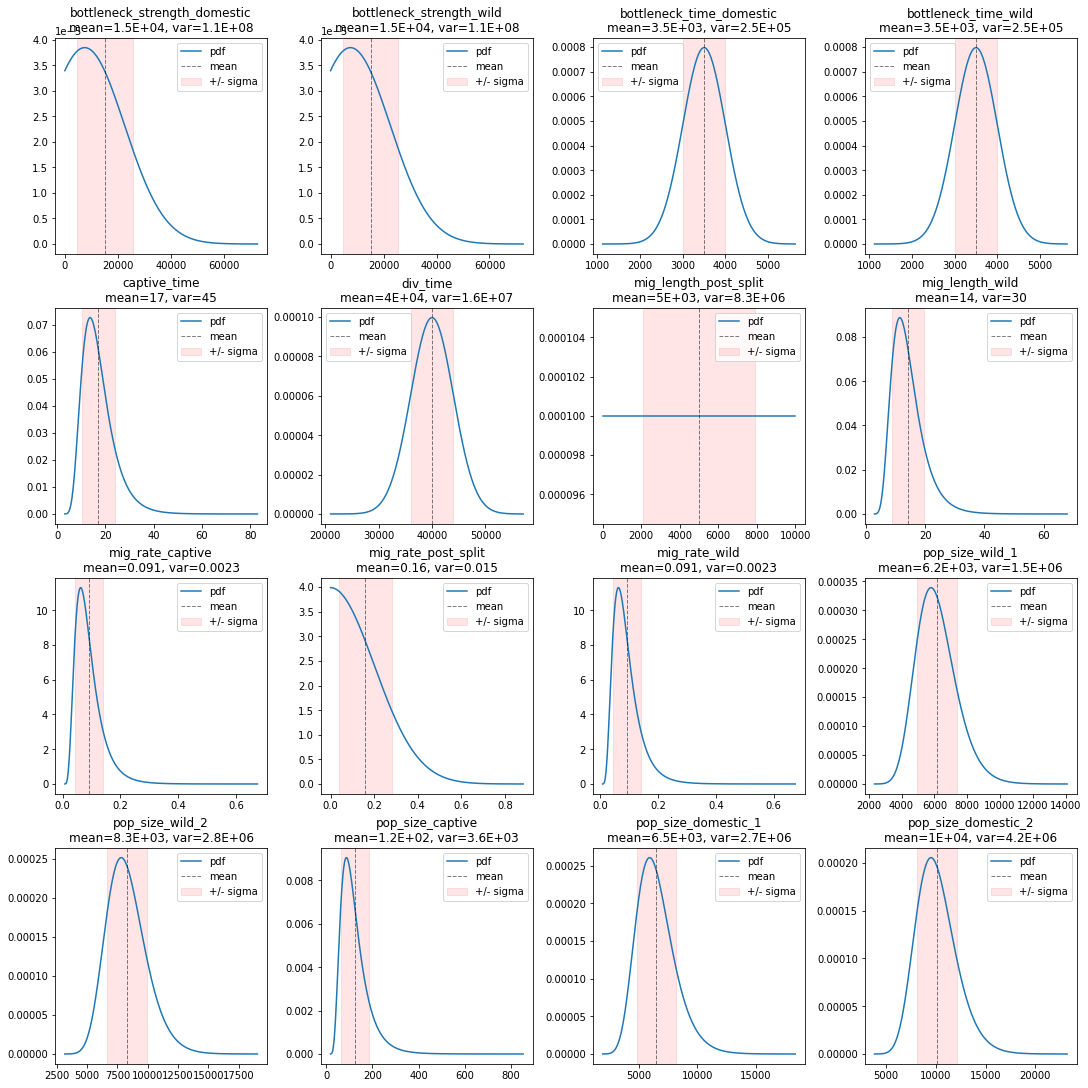

In [4]:
joint_prior = priors.join_priors()
priors.plot_all_priors()

In [5]:
def wildcat_simulator(params):
    """
    Takes setss of the 16 parameters as input, returns the summary statistics in lists
    """
    length=int(10e6)
    recombination_rate=1.8e-8
    mutation_rate=6e-8
    
    params = np.array(params)
    print("Starting simulation...")
    data = simple_sim(*params, length, recombination_rate, mutation_rate, seed=200)
    
    print("Calculating summary statistics...")
    summary_stats = simple_sum(data)
    
    print("Simulation complete")
    return torch.Tensor(list(summary_stats.values()))

In [6]:
# Compare the result of simulating a set of parameters with each row of statistics
# It doesn't seem that the simulator outputs statistics similar to any of the rows
#   of the stats csv
def compare_params_with_stats():
    stats = wildcat_simulator(priors_df.values[0])
    min_diff = np.inf
    min_diff_index = None
    for data, i in zip(stats_df.loc, range(len(stats_df) - 1)):
        diff = Tensor(list(data[:-1])) - stats
        diff2 = diff * diff
        total = float(diff2.sum())
        if total < min_diff:
            min_diff = total
            min_diff_index = i
            print(f'min diff: {min_diff}, index: {min_diff_index}')
    print(f'Simulated statistics closest to row index {min_diff_index} of the statistics csv')


## Inference

In [7]:
# Get the simulator and prior in the right format for sbi

#simulator, prior = prepare_for_sbi(wildcat_simulator, joint_prior)
prior, _, _ = process_prior(joint_prior)

In [8]:
num_simulations = 10000
num_stats_to_use = 20

In [9]:
# Run the simulations

# theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=5)
theta = Tensor(priors_df.values[:num_simulations])
x = Tensor([stats[:num_stats_to_use] for stats in stats_df.values[:num_simulations]])
print(f'{theta.shape = }')
print(f'{x.shape = }')

theta.shape = torch.Size([10000, 16])
x.shape = torch.Size([10000, 20])


In [10]:
# Calculate the posterior

inference = SNLE(prior=prior).append_simulations(theta, x)
density_estimator = inference.train(show_train_summary=True)
posterior = inference.build_posterior(density_estimator)
print(posterior)

Neural network successfully converged after 153 epochs.

        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 153
        Best validation performance: 108.6508
        -------------------------
        
Posterior conditional density p(θ|x) (amortized).

This LikelihoodBasedPosterior-object was obtained with a SNLE-class method using a flow.
It provides MCMC to .sample() from the posterior and can evaluate the _unnormalized_ posterior density with .log_prob().


In [11]:
# We observe x_o
x_o = Tensor(stats_df.values[0][:num_stats_to_use])
print(f'{x_o.shape = }')

x_o.shape = torch.Size([20])
log_prob = tensor([4.0169])


 /home/jack/.conda/envs/wildcats/lib/python3.9/site-packages/sbi/inference/posteriors/likelihood_based_posterior.py:99: UserWarning:The log probability from SNL is only correct up to a normalizing constant.


In [ ]:
posterior_samples = posterior.sample((50,), x=x_o)

In [ ]:
# plot posterior samples
_ = analysis.pairplot(posterior_samples, figsize=(5,5))